In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score


In [ ]:
# 1. Load dataset

dataset = load_dataset("ag_news")


In [ ]:
# 2. Load tokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)


In [ ]:
# 3. Tokenize dataset

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Define train and test sets
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

In [ ]:
# Define train and test sets

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 4. Load model

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [ ]:
# 5. Metrics

training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,
    eval_steps=500,
    save_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,      # make it smaller first to test
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
)

In [ ]:
# 6. TrainingArguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset.shuffle().select(range(2000)),  # smaller subset for speed
    eval_dataset=test_dataset.shuffle().select(range(500)),
    compute_metrics=compute_metrics,
)


In [ ]:
# 7. Trainer

trainer.train()



c:\Users\Ahsan Computer\miniconda3\envs\first_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,1.093800
100,0.569400


TrainOutput(global_step=125, training_loss=0.7563886642456055, metrics={'train_runtime': 2122.0967, 'train_samples_per_second': 0.942, 'train_steps_per_second': 0.059, 'total_flos': 131557890048000.0, 'train_loss': 0.7563886642456055, 'epoch': 1.0})

In [ ]:
# 9. Evaluate

results = trainer.evaluate()
print("Evaluation Results:", results)

c:\Users\Ahsan Computer\miniconda3\envs\first_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluation Results: {'eval_loss': 0.439689576625824, 'eval_accuracy': 0.868, 'eval_f1': 0.8673660898634302, 'eval_runtime': 140.6375, 'eval_samples_per_second': 3.555, 'eval_steps_per_second': 0.228, 'epoch': 1.0}


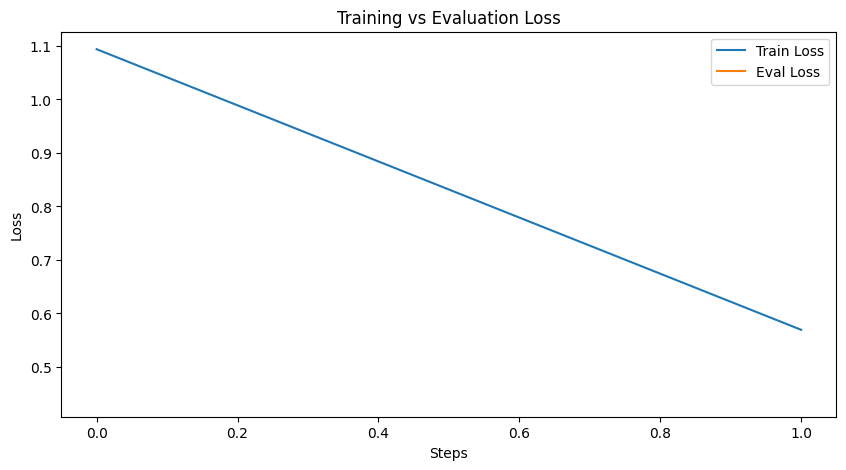

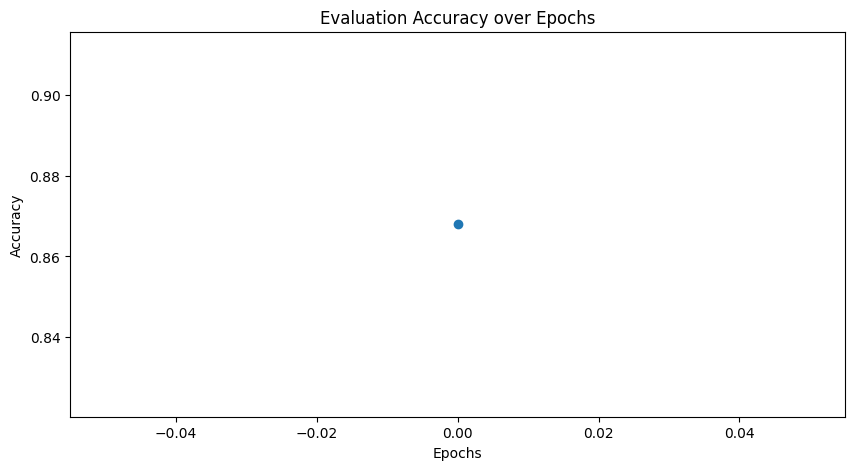

In [19]:
import matplotlib.pyplot as plt

# Trainer keeps logs in history
history = trainer.state.log_history

train_loss = [x["loss"] for x in history if "loss" in x]
eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
eval_acc = [x["eval_accuracy"] for x in history if "eval_accuracy" in x]

plt.figure(figsize=(10,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(eval_acc, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy over Epochs")
plt.show()


c:\Users\Ahsan Computer\miniconda3\envs\first_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


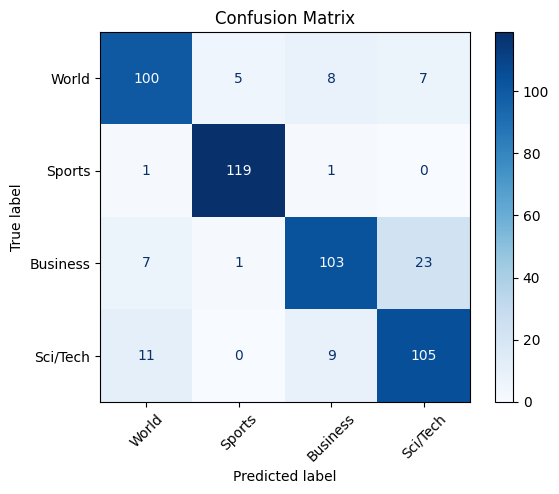

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
preds = trainer.predict(test_dataset.shuffle().select(range(500)))
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["World", "Sports", "Business", "Sci/Tech"])
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [22]:
import pandas as pd

# Pick some raw examples
examples = dataset["test"].shuffle().select(range(10))

# Tokenize them (drop labels for inference)
tokenized_examples = examples.map(tokenize_function, batched=True)
tokenized_examples.set_format("torch", columns=["input_ids", "attention_mask"])

# Run predictions
preds = trainer.predict(tokenized_examples)
pred_classes = preds.predictions.argmax(axis=1)

# Make a nice table
df = pd.DataFrame({
    "Headline": examples["text"],
    "True Label": [ ["World","Sports","Business","Sci/Tech"][l] for l in examples["label"]],
    "Predicted": [ ["World","Sports","Business","Sci/Tech"][p] for p in pred_classes ]
})
df


Map: 100%|██████████| 10/10 [00:00<00:00, 45.01 examples/s]


,Headline,True Label,Predicted
0,MEPs threaten to sink commission over Buttigli...,World,World
1,Hearing held on Hamm medal Paul Hamm said yest...,Sports,Sports
2,Modified US space shuttle ready to fly next sp...,Sci/Tech,Sci/Tech
3,"Mosley Unable to Escape Winkys Jab Las Vegas, ...",Sports,Sports
4,Warped Satellites Prove Einstein Theory -Scien...,Sci/Tech,Sci/Tech
5,Scientists Prepare for Huygens' Plunge into Ti...,Sci/Tech,Sci/Tech
6,IBM fits PCs with new hardware-based security ...,Sci/Tech,Sci/Tech
7,Federer relieved to return Roger Federer still...,Sports,Sports
8,Good Luck and Bubblewrap.com Collard greens an...,Sci/Tech,Sci/Tech
9,(B)old new frontiers Northrop Grumman Corp. an...,Business,Sci/Tech


In [23]:
import gradio as gr

labels_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

def predict(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    outputs = model(**tokens)
    pred = torch.argmax(outputs.logits, dim=1).item()
    return labels_map[pred]

examples = [
    ["NASA announces new mission to Mars"],
    ["Stock markets crash amid inflation fears"],
    ["Real Madrid wins Champions League"],
    ["UN discusses climate change action"]
]

demo = gr.Interface(fn=predict, inputs="text", outputs="text", 
                    title="News Topic Classifier (BERT)",
                    description="Type or choose a news headline to see its predicted category.",
                    examples=examples)
demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
